<a href="https://colab.research.google.com/github/pranavrelds/rossmann-store-sales-using-fbprophet/blob/main/Rossmann_Store_Sales_Prediction_Fbprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Libraries 

In [46]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from fbprophet import Prophet
import matplotlib.pyplot as plt

# Configurations

In [9]:
DIR = '/content/drive/MyDrive/Rossmann Store Sales/'

DF_TRAIN = pd.read_csv(DIR+'train.csv')
DF_STORE = pd.read_csv(DIR+'store.csv')

# Loading Dataset

In [10]:
DF_TRAIN.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [11]:
DF_TRAIN.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [13]:
DF_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [12]:
DF_STORE.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [14]:
DF_STORE.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [16]:
DF_STORE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


# EDA

## Checking for missing values in Sales Data

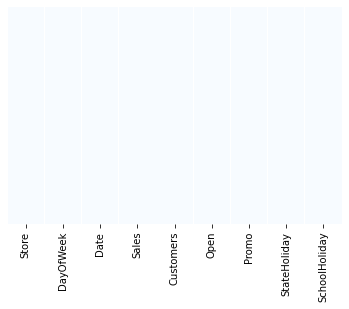

In [17]:
sns.heatmap(DF_TRAIN.isnull(), yticklabels=False, cbar= False, cmap='Blues')
plt.show()

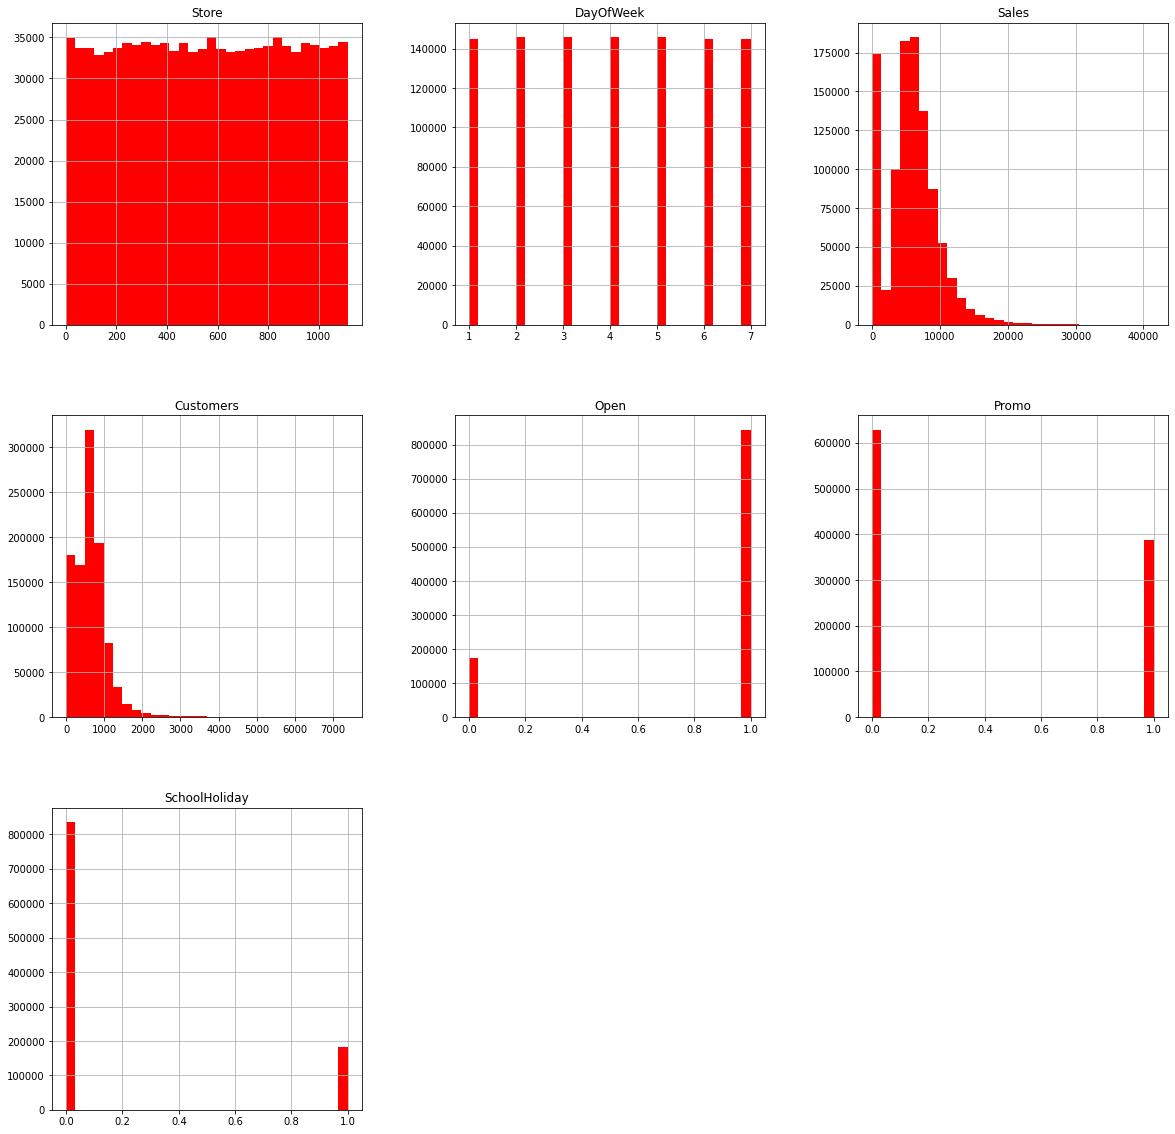

In [18]:
DF_TRAIN.hist(bins=30, figsize =(20,20), color ='r')
plt.show()

**Observation:**
* Average 600 customers per day
* Data is equally distibuted across various Days of the week
* Stores are open ~80% of the time
* Data is equally distributed among all stores
* Promo 1 was running ~40% of the time 
* Average sales around 5000-6000 Euros
* School holidays are around ~18% of the time

In [ ]:
# Number of stores open and closed 
DF_TRAIN['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [21]:
# Keeping stores which are open and removing closed stores
DF_TRAIN = DF_TRAIN[DF_TRAIN['Open'] == 1]
DF_TRAIN.drop('Open', axis=1, inplace=True)
DF_TRAIN.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


**Observation:** 
Average number of customers increased from 633 to 762

##  Checking for missing values in Store Data

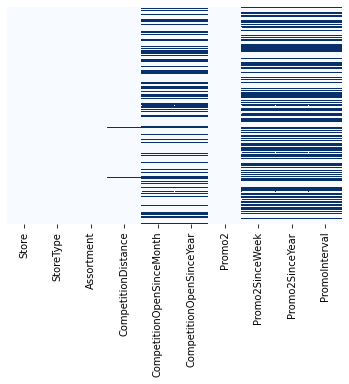

In [22]:
sns.heatmap(DF_STORE.isnull(), yticklabels=False, cbar=False, cmap='Blues')
plt.show()

In [ ]:
# Missing values in the 'CompetitionDistance'
DF_STORE[DF_STORE['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
# Missing values in the 'CompetitionOpenSinceMonth'
DF_STORE[DF_STORE['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


**Observation:**

Many rows are missing = 354 (almost one third of the 1115 stores)

In [23]:
DF_STORE['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [ ]:
# Exploring Promo2
DF_STORE[DF_STORE['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


**Observation:**

* When 'promo2' is zero, 'Promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' are set to zero
* 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing


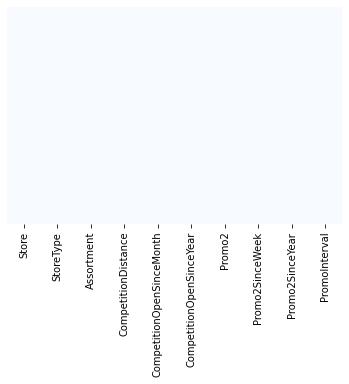

In [32]:
# Set these values to zeros 
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']
for str in str_cols:
  DF_STORE[str].fillna(0, inplace = True)

# Mean imputation of CompetitionDistance for 3 missing values
DF_STORE['CompetitionDistance'].fillna(DF_STORE['CompetitionDistance'].mean(), inplace = True)

# Checking for missing value again
sns.heatmap(DF_STORE.isnull(), yticklabels=False, cbar=False, cmap='Blues')
plt.show()

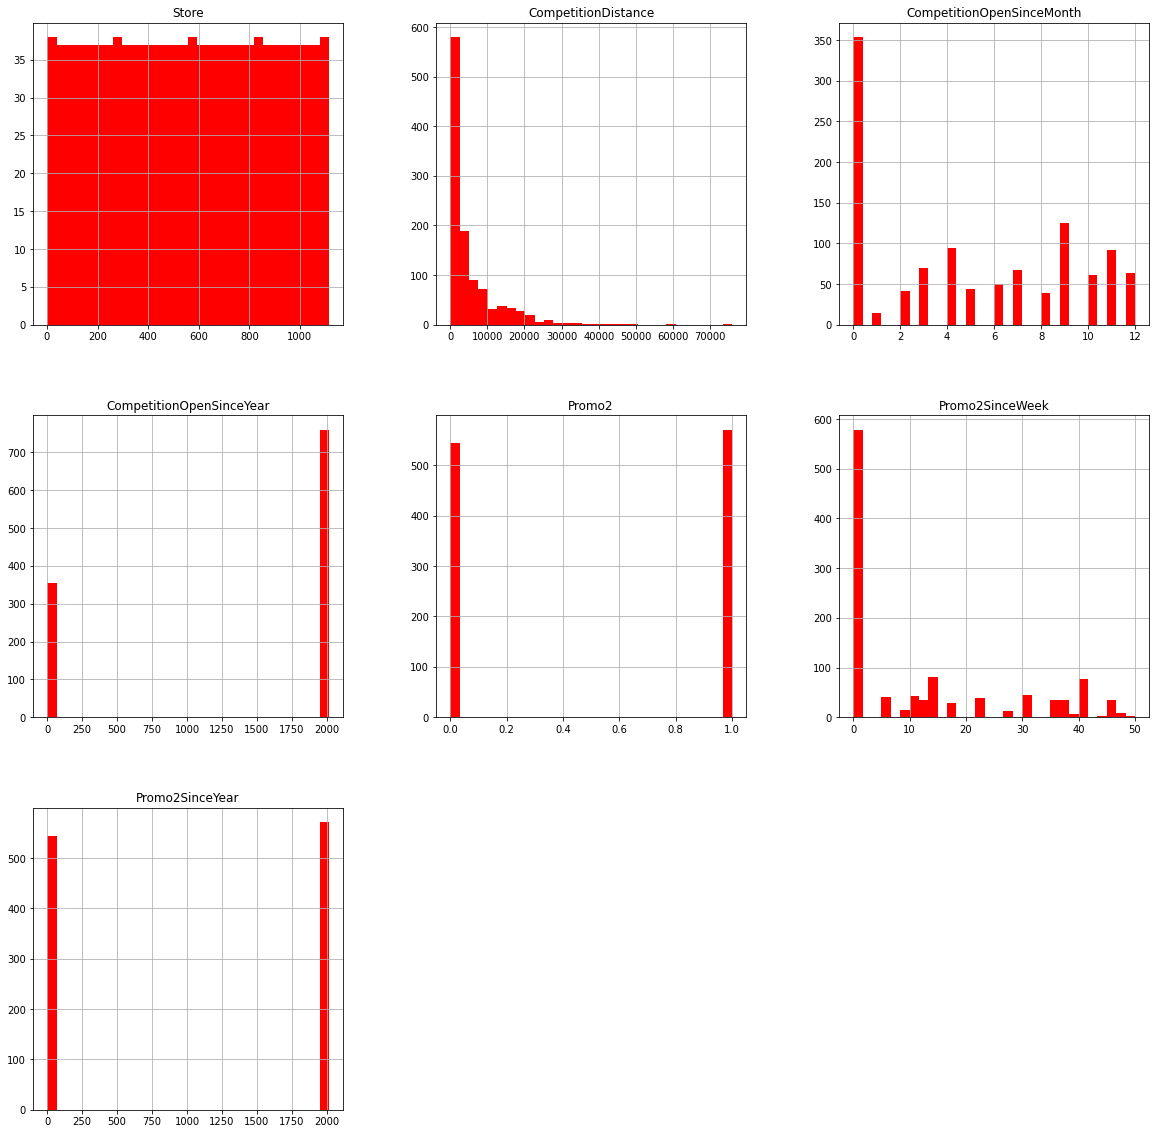

In [33]:
DF_STORE.hist(bins= 30, color = 'r', figsize =(20,20))
plt.show()

**Observation:**
* Nearly half of stores are involved in promo 2
* More than half of the stores have competition at a distance of 0-3km

## Merging Sales and Store data

In [34]:
DF = pd.merge(DF_TRAIN, DF_STORE, how = 'inner', on = 'Store')
DF.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [35]:
# Correlation of other features with Sales
correlations = DF.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

**Observation:**

* Customers and promo are positively correlated with the sales 
* Promo2 is not effective

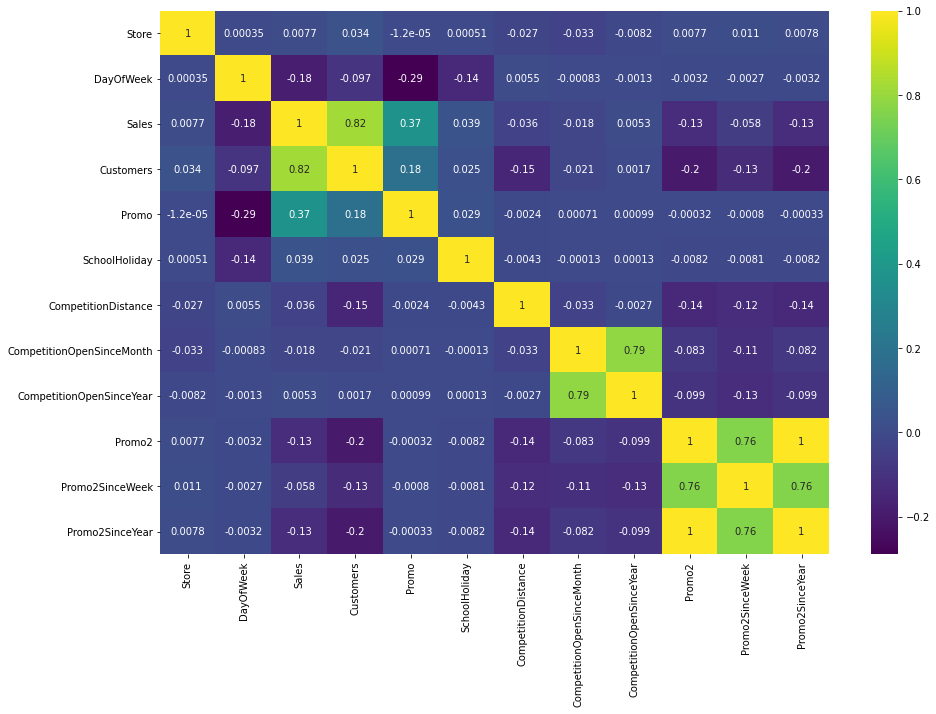

In [38]:
plt.figure(figsize = (15,10))
sns.heatmap(DF.corr(), annot=True, cmap='viridis')
plt.show()

**Observation:**
Customers/Promo and sales are strongly correlated 

In [40]:
# Separate the year, month and day into seperate columns
DF['Year'] = pd.DatetimeIndex(DF['Date']).year
DF['Month'] = pd.DatetimeIndex(DF['Date']).month
DF['Day'] = pd.DatetimeIndex(DF['Date']).day
DF.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


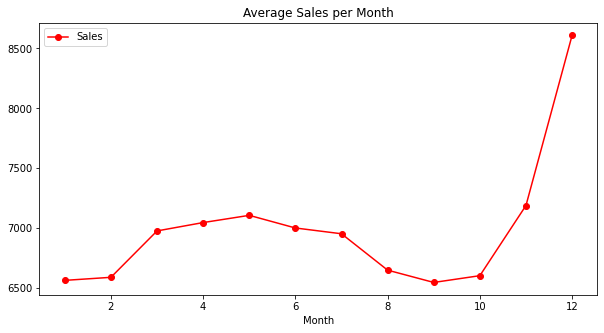

In [61]:
# Average sales per month
axis = DF.groupby('Month')[['Sales']].mean().plot(figsize= (10,5), marker ='o', color = 'r')
axis.set_title('Average Sales per Month')
plt.show()

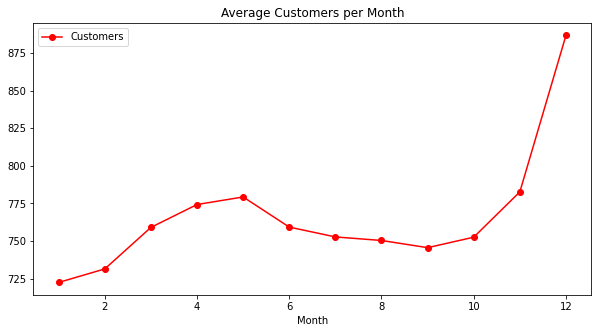

In [63]:
# Average customer per month
cust = DF.groupby('Month')[['Customers']].mean().plot(figsize =(10,5), marker ='o', color ='r')
cust.set_title('Average Customers per Month')
plt.show()

**Observation:**
Sales and number of customers peaks in December

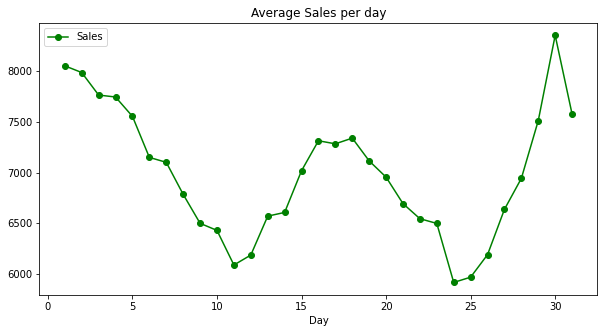

In [64]:
# Average Sales per day
sales_per_day = DF.groupby('Day')[['Sales']].mean().plot(figsize =(10,5), marker ='o', color ='g')
sales_per_day.set_title('Average Sales per day')
plt.show()

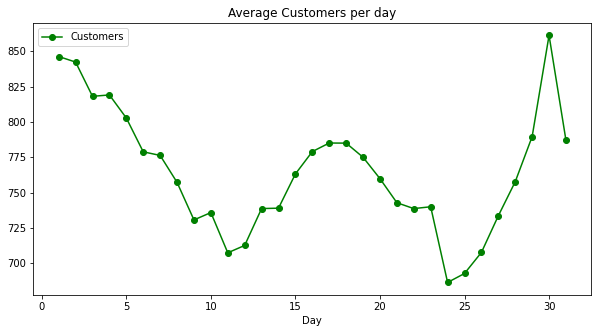

In [65]:
cust_per_day = DF.groupby('Day')[['Customers']].mean().plot(figsize =(10,5), marker ='o', color ='g')
cust_per_day.set_title('Average Customers per day')
plt.show()

**Observation:**
* Maximum sales are around 30th and 1st of the month
* Number of customers dropped between the 20th to 24th of the month 

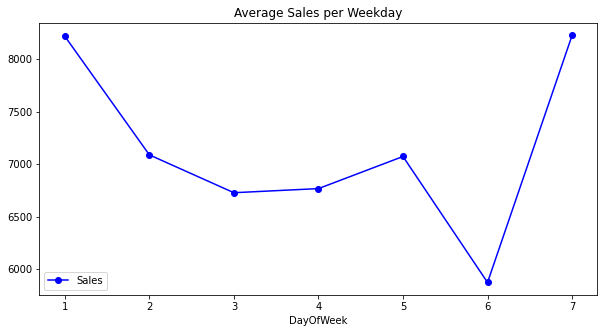

In [66]:
# Average Sales per Weekday
sales_per_weekday = DF.groupby('DayOfWeek')[['Sales']].mean().plot(figsize =(10,5), marker ='o', color ='b')
sales_per_weekday.set_title('Average Sales per Weekday')
plt.show()

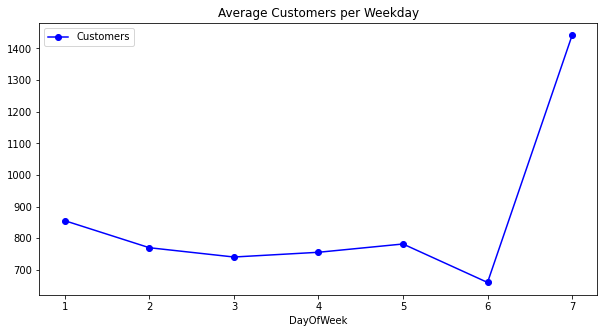

In [67]:
cust_per_weekday = DF.groupby('DayOfWeek')[['Customers']].mean().plot(figsize =(10,5), marker ='o', color ='b')
cust_per_weekday.set_title('Average Customers per Weekday')
plt.show()

**Observation:**
* Sales is high in start and end of the week
* Number of customers increase on the weekend

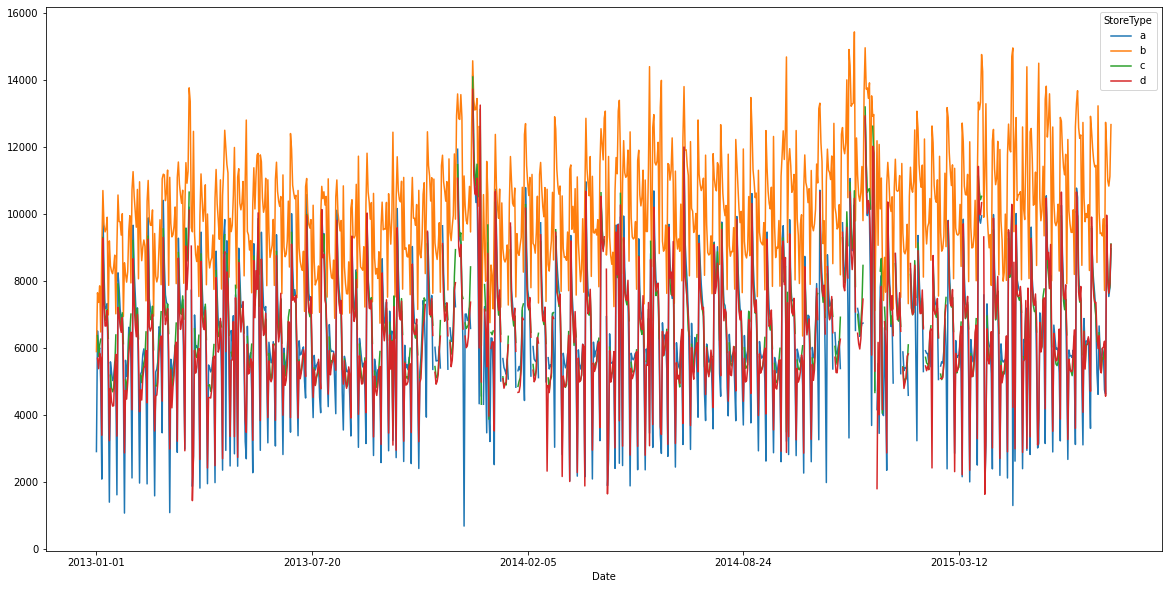

In [42]:
# Sales based on store type and Date
fig, ax = plt.subplots(figsize=(20,10))
DF.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax=ax)
plt.show()

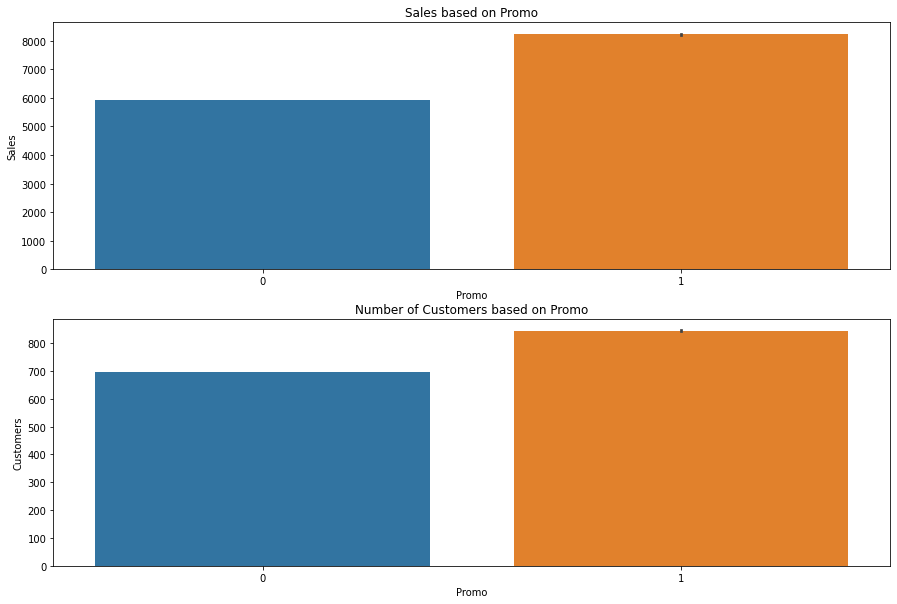

In [68]:
plt.figure(figsize=(15,10))
plt.subplot(211)
sns.barplot(x='Promo', y='Sales', data=DF)
plt.title('Sales based on Promo')
plt.subplot(212)
sns.barplot(x='Promo', y='Customers', data=DF)
plt.title('Number of Customers based on Promo')
plt.show()

**Observation:**
Increase in sales and number of customers when there is a promo

# Model

In [51]:
# Get holdidays 
state_holidays = DF[(DF['StateHoliday']== 'a') | (DF['StateHoliday']== 'b' ) | (DF['StateHoliday']== 'c' )].loc[:,'Date'].values
school_holidays = DF[DF['SchoolHoliday']==1].loc[:,'Date'].values

In [52]:
# Creating dataframe of state and school holidays
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})
school_holidays = pd.DataFrame({'ds':pd.to_datetime(school_holidays), 
                                'holiday': 'school_holiday'})

# Concatinate all holidays into one dataframe
holidays =pd.concat((state_holidays, school_holidays))
holidays.head()

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday


In [56]:
def predict_sales(Store_ID, df, periods, holidays):
  """
  Takes in the storeID and returns two date and sales columns in Prophet format.
  Fits data to the model and plots graph of the future period
  """
  # Get all the data for the given Store_ID
  df = df [df['Store'] == Store_ID]
  # Formatting data to fit prophet model
  df = df[['Date','Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  df = df.sort_values('ds')

  # Define model
  model = Prophet(holidays= holidays) 
  model.fit(df)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)
  figure1 = model.plot(forecast, xlabel = 'Date', ylabel ='Sales')
  figure2 = model.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


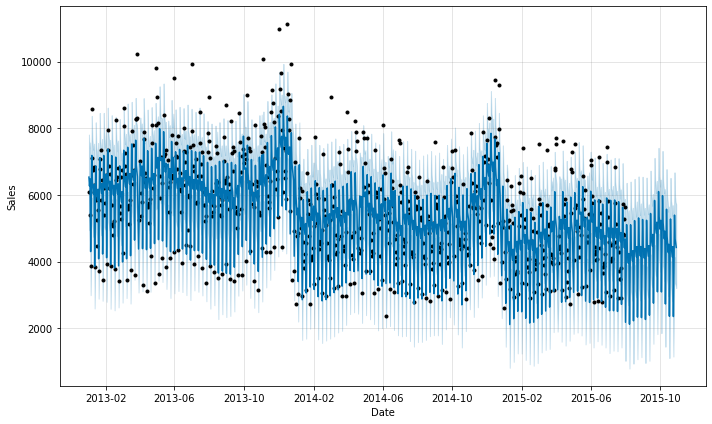

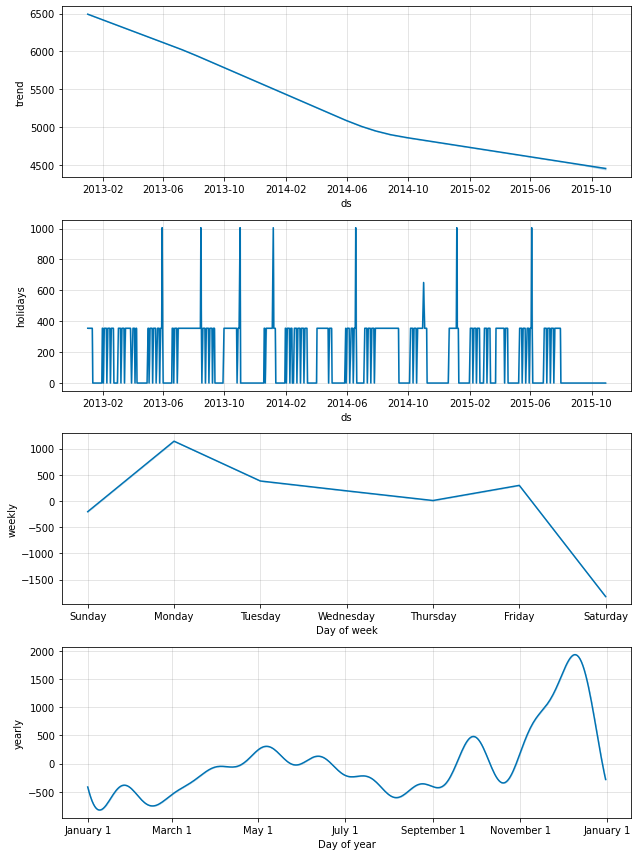

In [57]:
predict_sales(6, DF, 90 ,holidays)